Возьмём код с семинара и добавим возможность менять $\alpha$ со временем

In [74]:
## based on http://inst.eecs.berkeley.edu/~cs188/sp09/pacman.html

import random,math

import numpy as np
from collections import defaultdict

class QLearningAgent:
    """
    Q-Learning Agent
    Instance variables you have access to
      - self.epsilon (exploration prob)
      - self.alpha (learning rate)
      - self.discount (discount rate aka gamma)
    Functions you should use
      - self.getLegalActions(state)
        which returns legal actions for a state
      - self.getQValue(state,action)
        which returns Q(state,action)
      - self.setQValue(state,action,value)
        which sets Q(state,action) := value
    
    !!!Important!!!
    NOTE: please avoid using self._qValues directly to make code cleaner
    """
    def __init__(self,alpha,epsilon,discount,getLegalActions,
                 alpha_changer_functor = None):
        "We initialize agent and Q-values here."
        self.getLegalActions= getLegalActions
        self._qValues = defaultdict(lambda:defaultdict(lambda:0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
        self.alpha_changer = None
        if alpha_changer_functor is not None:
            self.alpha_changer = alpha_changer_functor()

    def getQValue(self, state, action):
        """
          Returns Q(state,action)
        """
        return self._qValues[state][action]

    def setQValue(self,state,action,value):
        """
          Sets the Qvalue for [state,action] to the given value
        """
        self._qValues[state][action] = value

#---------------------#start of your code#---------------------#

    def getValue(self, state):
        """
          Returns max_action Q(state,action)
          where the max is over legal actions.
        """

        possibleActions = self.getLegalActions(state)
        #If there are no legal actions, return 0.0
        if len(possibleActions) == 0:
            return 0.0

        "*** YOUR CODE HERE ***"
        return np.max(np.array(
            map(lambda action: self.getQValue(state, action), possibleActions)))
    
    def getPolicy(self, state):
        """
          Compute the best action to take in a state. 

        """
        possibleActions = self.getLegalActions(state)

        #If there are no legal actions, return None
        if len(possibleActions) == 0:
            return None

        best_action = None

        "*** YOUR CODE HERE ***"
        best_action = possibleActions[
            np.argmax(np.array(map(lambda action: self.getQValue(state, action), possibleActions)))]
        return best_action

    def getAction(self, state):
        """
          Compute the action to take in the current state, including exploration.  

          With probability self.epsilon, we should take a random action.
          otherwise - the best policy action (self.getPolicy).
          HINT: You might want to use util.flipCoin(prob)
          HINT: To pick randomly from a list, use random.choice(list)
        """

        # Pick Action
        possibleActions = self.getLegalActions(state)
        action = None

        #If there are no legal actions, return None
        if len(possibleActions) == 0:
            return None

        #agent parameters:
        epsilon = self.epsilon

        "*** YOUR CODE HERE ***"
        
        # return <put agent's action here>
        random_action = np.random.choice(np.array(possibleActions), 1)
        random_threshold = np.random.uniform(low = 0, high = 1)
        if random_threshold < self.epsilon:
            return random_action[0]
        else:
            return self.getPolicy(state)
        

    def update(self, state, action, nextState, reward):
        """
          You should do your Q-Value update here
          NOTE: You should never call this function,
          it will be called on your behalf
        """
        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        "*** YOUR CODE HERE ***"
        reference_qvalue = reward + gamma * self.getValue(nextState)
        #reference_qvalue = <the "correct state value", uses reward and the value of next state>

        updated_qvalue = (1-learning_rate) * self.getQValue(state,action) + learning_rate * reference_qvalue
        self.setQValue(state,action,updated_qvalue)
        if self.alpha_changer is not None:
            self.alpha = self.alpha_changer()

#---------------------#end of your code#---------------------#

In [75]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [76]:
import gym
env = gym.make("Taxi-v2")

n_actions = env.action_space.n

[2018-01-28 16:01:46,989] Making new env: Taxi-v2


Мы сделаем $\alpha$ убывающим со временем. При этом он будет убывать разрывно, ибо вначале $\alpha$ требуется большим для обновления значений qValues максимально эффективно. $\varesilon$ тоже повысим, чтобы просматривать больше вариантов вначале, при этом уменьшать её, аналогично $\alpha$ будем не на каждом шаге.

In [226]:
class step_reciproc_alpha_changer:
    def __init__(self):
        self.step_num = 1.
    def __call__(self):
        self.step_num += 1
        scaler = float(int(self.step_num/1500))*0.3 + 1.5
        return 1./scaler
        

agent = QLearningAgent(alpha=0.5,epsilon=0.6,discount=0.9999,
                       getLegalActions = lambda s: range(n_actions),
                       alpha_changer_functor = step_reciproc_alpha_changer)


В следующей функции число итераций увеличим

In [227]:
def play_and_train(env,agent,t_max=10**5):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        #a = <get agent to pick action given state s>
        a = agent.getAction(s)
        
        next_s,r,done,prob = env.step(a)
        
        #<train(update) agent for state s>
        agent.update(s,a,next_s,r)
        
        s = next_s
        total_reward +=r
        if done:
            break
        
    return total_reward

Чтобы исключить влияние случайности, будем брать среднюю награду по 20 последним play_and_train. При этом будем считать средний скор по 100 независимым запускам всего процесса. Напишем конечную $\varepsilon$ (одинаковая во всех запусках) и график для одного запуска. В конце напишем средний скор для 100 запусков и их гистограмму

1e-06


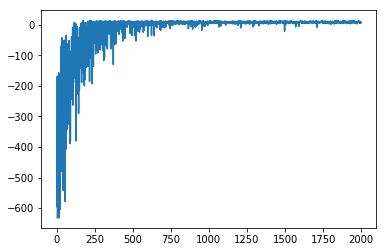

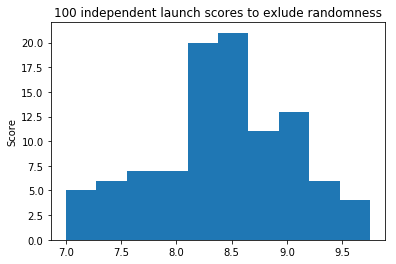

8.401


In [230]:
def make_one_score():
    agent = QLearningAgent(alpha=0.6,epsilon=0.6,discount=0.9999,
                       getLegalActions = lambda s: range(n_actions),
                       alpha_changer_functor = step_reciproc_alpha_changer)
    rewards = []
    for i in range(2000):
        rewards.append(play_and_train(env,agent))

        if i % 100 == 0:
            agent.epsilon = max(agent.epsilon * 0.3, 1e-6)

        if i %500 ==499:
            clear_output(True)
            print agent.epsilon
            plt.plot(rewards)
            plt.show()
    return np.mean(rewards[-20:])

scores = np.array([make_one_score() for _ in range(100)])
plt.hist(scores, bins = 10)
plt.ylabel('Score')
plt.title('100 independent launch scores to exlude randomness')
plt.show()
print np.mean(scores)